Orientals dataset size: 501
Training set size: 400
Testing set size: 101
Indians dataset size: 485
Europeans dataset size: 500
Epoch [1/100], Training Loss: 0.3691, Testing Loss: 0.1995
Epoch [2/100], Training Loss: 0.1028, Testing Loss: 0.0442
Epoch [3/100], Training Loss: 0.0394, Testing Loss: 0.0289
Epoch [4/100], Training Loss: 0.0274, Testing Loss: 0.0209
Epoch [5/100], Training Loss: 0.0209, Testing Loss: 0.0170
Epoch [6/100], Training Loss: 0.0170, Testing Loss: 0.0141
Epoch [7/100], Training Loss: 0.0141, Testing Loss: 0.0118
Epoch [8/100], Training Loss: 0.0125, Testing Loss: 0.0098
Epoch [9/100], Training Loss: 0.0112, Testing Loss: 0.0097
Epoch [10/100], Training Loss: 0.0100, Testing Loss: 0.0085
Epoch [11/100], Training Loss: 0.0091, Testing Loss: 0.0081
Epoch [12/100], Training Loss: 0.0081, Testing Loss: 0.0068
Epoch [13/100], Training Loss: 0.0073, Testing Loss: 0.0064
Epoch [14/100], Training Loss: 0.0062, Testing Loss: 0.0056
Epoch [15/100], Training Loss: 0.0057, Tes

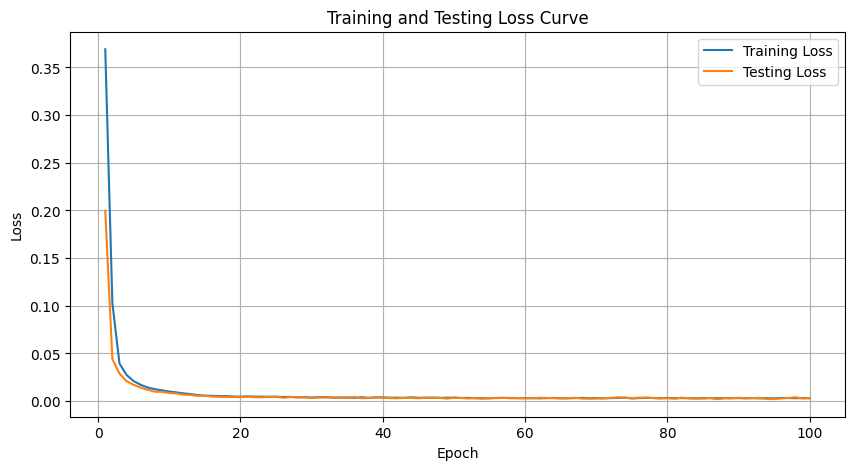

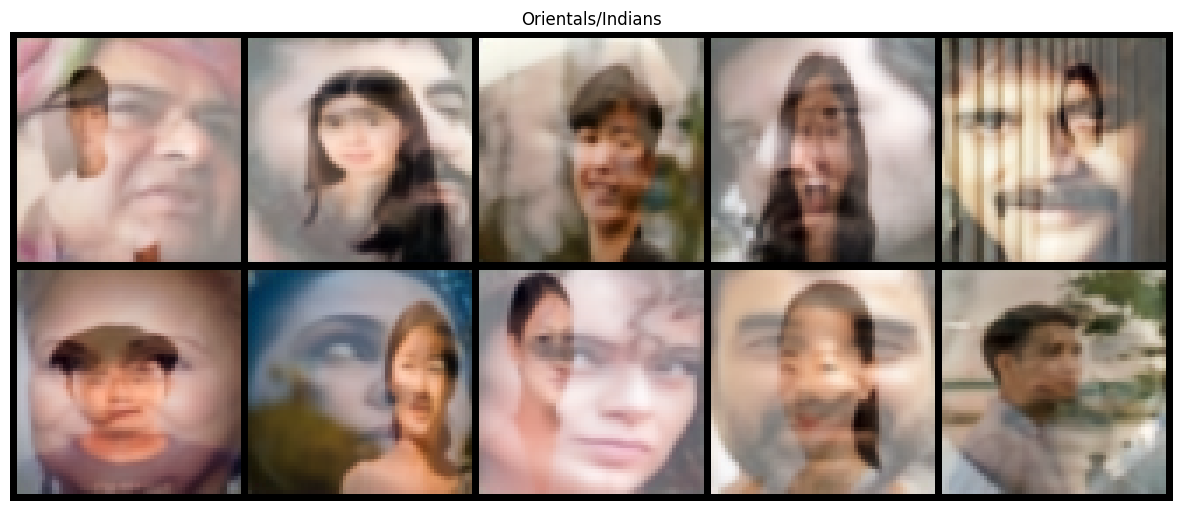

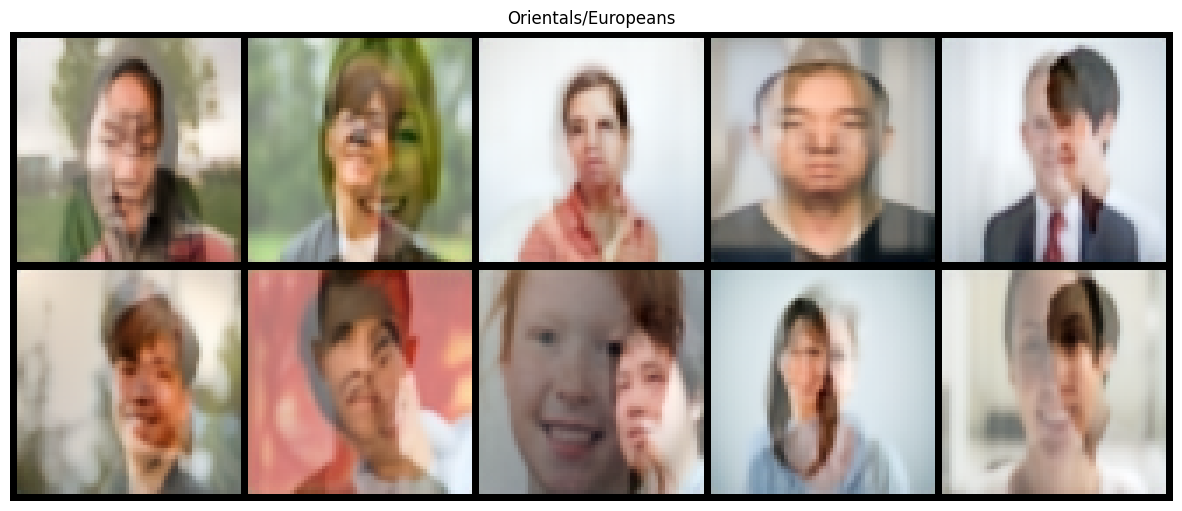

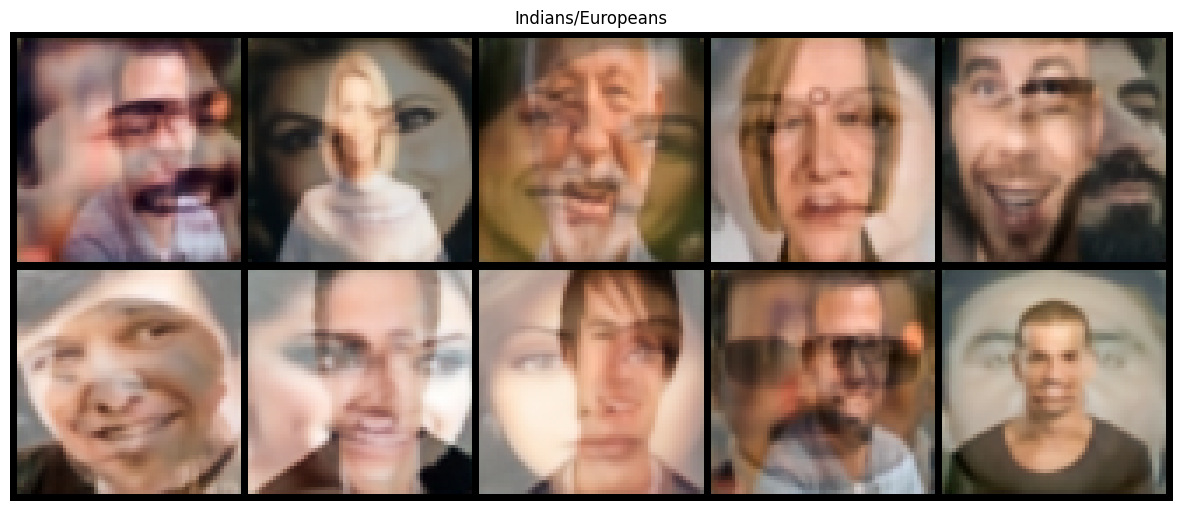

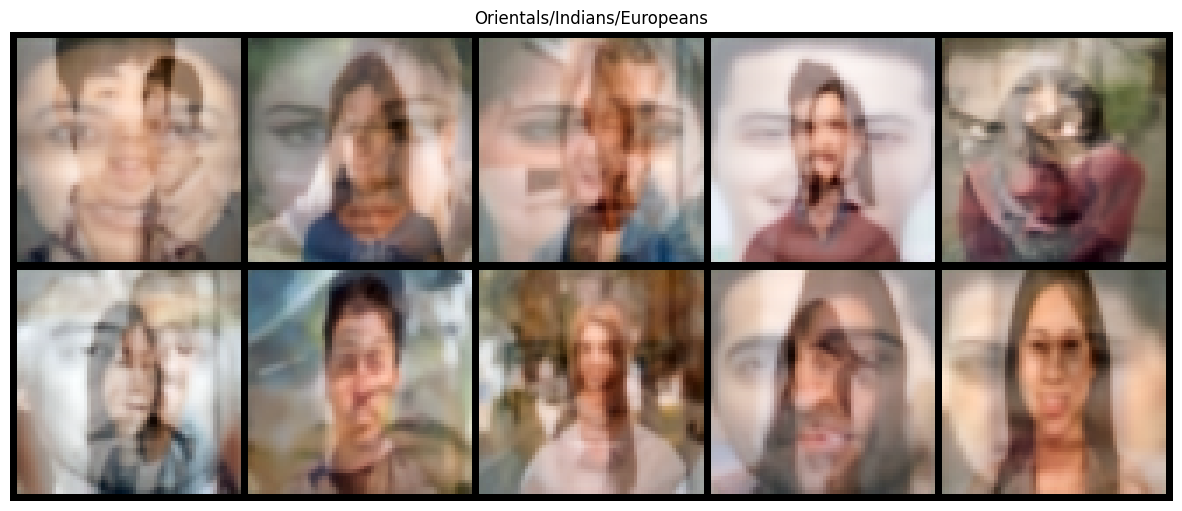

Image generation and saving completed.


In [7]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

# Mounting Google Drive to save generated images directly
#drive.mount('/content/drive')

# Define dataset and output directories
dataset_directory = '/content/drive/MyDrive/Images-Dataset'
output_directory = '/content/drive/MyDrive/Generated_Mixed_Images'
os.makedirs(output_directory, exist_ok=True)

# Ensuring if the dataset directory exists; raise an error if not found
if not os.path.exists(dataset_directory):
    raise FileNotFoundError(f"The dataset path {dataset_directory} does not exist.")

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_list = [
            os.path.join(folder_path, img_file)
            for img_file in os.listdir(folder_path)
            if img_file.endswith(('png', 'jpg', 'jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define image transformations:
# Resize all images to 64x64 pixels and normalize pixel values to the range [-1, 1]
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets for each demographic group (Orientals, Indians, Europeans).
# Each dataset contains images preprocessed using the defined transformations.
orientals_dataset_full = ImageDataset(os.path.join(dataset_directory, 'Orientals'), transform=data_transforms)
indians_dataset = ImageDataset(os.path.join(dataset_directory, 'Indians'), transform=data_transforms)
europeans_dataset = ImageDataset(os.path.join(dataset_directory, 'Europeans'), transform=data_transforms)

# Split the Orientals dataset into training (80%) and testing (20%) subsets
train_size = int(0.8 * len(orientals_dataset_full))
test_size = len(orientals_dataset_full) - train_size
orientals_train_dataset, orientals_test_dataset = random_split(orientals_dataset_full, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(orientals_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(orientals_test_dataset, batch_size=16, shuffle=False)

# Verify dataset sizes
print(f"Orientals dataset size: {len(orientals_dataset_full)}")
print(f"Training set size: {len(orientals_train_dataset)}")
print(f"Testing set size: {len(orientals_test_dataset)}")
print(f"Indians dataset size: {len(indians_dataset)}")
print(f"Europeans dataset size: {len(europeans_dataset)}")

# Define the UNet-based Diffusion Model:
# The model includes:
# - Encoder: Extracts high-level features from input images
# - Bottleneck: Processes these features to add/remove noise
# - Decoder: Reconstructs images from denoised features
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        # Encoder layers
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bottleneck layer
        self.bottleneck_layer = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder layers
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_layer1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder_layer1(x)
        enc2 = self.encoder_layer2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck_layer(self.pool2(enc2))

        # Decoding path
        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder_layer2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder_layer1(dec1)

        # Output layer:
        # Reduces the final feature map to a 3-channel RGB image
        output = self.output_layer(dec1)
        return output

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = SimpleUNet().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate

# Training Loop:
# The model is trained for `num_epochs` iterations to learn the denoising process.
# Loss values are computed for both training and testing data.
# Loss curves are logged to visualize model performance over time.
num_epochs = 100  # Number of epochs as needed
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch_images in train_loader:
        batch_images = batch_images.to(device)
        # Add Gaussian noise to the input images:
        # The noise is randomly scaled between 0.05 and 0.2 to simulate the diffusion process.
        noise = torch.randn_like(batch_images) * np.random.uniform(0.05, 0.2)
        noisy_inputs = batch_images + noise

        # Forward pass
        denoised_outputs = model(noisy_inputs)

        # Compute Mean Squared Error (MSE) loss:
        # It measures the difference between the model's denoised output and the original clean image.
        loss = loss_function(denoised_outputs, batch_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(average_train_loss)

    # Testing phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_images in test_loader:
            batch_images = batch_images.to(device)
            # Adding random noise to the images
            noise = torch.randn_like(batch_images) * np.random.uniform(0.05, 0.2)
            noisy_inputs = batch_images + noise

            # Forward pass
            denoised_outputs = model(noisy_inputs)

            # Compute the loss
            loss = loss_function(denoised_outputs, batch_images)
            total_test_loss += loss.item()

    average_test_loss = total_test_loss / len(test_loader)
    test_loss_history.append(average_test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_train_loss:.4f}, "
          f"Testing Loss: {average_test_loss:.4f}")

# Plotting of training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_loss_history, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.grid(True)
plt.legend()
plt.show()

# Function: `generate_and_save_images`
# This function takes datasets of images and generates blended outputs by:
# 1. Randomly selecting images from each dataset
# 2. Mixing features of the selected images (averaging pixel values)
# 3. Passing the mixed input through the trained model to generate denoised images
# The function also:
# - Saves generated images in Google Drive for future use
# - Displays them as a grid in the notebook
def generate_and_save_images(model, dataset_a, dataset_b=None, dataset_c=None, title=""):
    model.eval()
    generated_images = []

    # Create a subfolder in the output directory to store generated images for each combination.
    # The folder name is based on the title of the combination (e.g., Orientals/Indians).
    combination_folder = os.path.join(output_directory, title.replace('/', '_'))
    os.makedirs(combination_folder, exist_ok=True)

    for idx in range(10):
        img_a = dataset_a[np.random.randint(0, len(dataset_a))].unsqueeze(0).to(device)
        if dataset_b:
            img_b = dataset_b[np.random.randint(0, len(dataset_b))].unsqueeze(0).to(device)
        else:
            img_b = 0

        if dataset_c:
            img_c = dataset_c[np.random.randint(0, len(dataset_c))].unsqueeze(0).to(device)
        else:
            img_c = 0

        # Mixing of the images
        num_images = 1 + (dataset_b is not None) + (dataset_c is not None)
        mixed_input = (img_a + img_b + img_c) / num_images

        # Generation of the output image
        with torch.no_grad():
            generated_output = model(mixed_input).squeeze(0).cpu()
            generated_images.append(generated_output)

            # Unnormalize and save the image
            image = generated_output.clone()
            image = (image * 0.5) + 0.5  # Unnormalize from [-1, 1] to [0, 1]
            image = image.clamp(0, 1)
            image = transforms.ToPILImage()(image)
            image.save(os.path.join(combination_folder, f"generated_image_{idx + 1}.png"))

    # Create a grid of images
    image_grid = make_grid(generated_images, nrow=5, normalize=True, scale_each=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(image_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate and Save Synthetic Images:
# For each combination of demographic groups, the function:
# - Randomly selects images from the input datasets
# - Generates mixed images using the trained diffusion model
# - Saves the generated images to Google Drive
# - Displays the generated images in a grid format
# Orientals + Indians
generate_and_save_images(model, orientals_dataset_full, indians_dataset, title="Orientals/Indians")

# Orientals + Europeans
generate_and_save_images(model, orientals_dataset_full, europeans_dataset, title="Orientals/Europeans")

# Indians + Europeans
generate_and_save_images(model, indians_dataset, europeans_dataset, title="Indians/Europeans")

# Orientals + Indians + Europeans
generate_and_save_images(model, orientals_dataset_full, indians_dataset, europeans_dataset, title="Orientals/Indians/Europeans")

print("Image generation and saving completed.")